# Projekt 1 - KM2
Zbiór danych nr 3: https://www.apispreadsheets.com/datasets/122

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

import scipy.stats

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


plt.rcParams['figure.figsize'] = (16,6)
# plt.rcParams['font.size'] = 20
# sns.set_context('paper', font_scale=1.4)
sns.set(font_scale = 1.3)
sns.set_style("ticks",{'axes.grid' : True})
sns.set_palette("deep")

### Przypomnienie
Zmienna docelowa przyjmuje sześć kategorii, czyli liczby od 1 do 6, które możemy tłumaczyć jako kolejne aktywności człowieka:
* WALKING
* WALKING_UPSTAIRS
* WALKING_DOWNSTAIRS
* SITTING
* STANDING
* LAYING

In [2]:
df = pd.read_csv('smartphone_activity_dataset.csv')

## Outliers
Poprzednim razem nie sprawdziliśmy wartości odstających. Dlatego teraz policzymy, ile wartości odstających (względem swojej kolumny) jest w każdym wierszu.

In [3]:
tmp = df.copy()
Q1 = tmp.quantile(0.25)
Q3 = tmp.quantile(0.75)
IQR = Q3 - Q1
tmp['outliers'] = ((tmp < (Q1 - 3*IQR)) | (tmp > (Q3 + 3*IQR))).sum(axis=1)
tmp['outliers_binned'] = pd.cut(tmp['outliers'], bins=[0, 1, 2, 6, 11, 51, 180], labels=['0', '1', '2-5', '6-10', '11-50', '>50'], right=False)

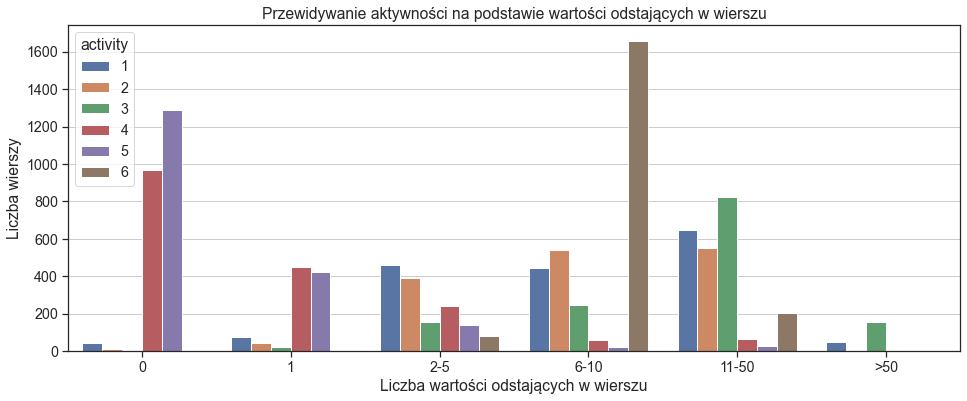

In [4]:
sns.countplot(data=tmp, x='outliers_binned', hue='activity')
plt.title("Przewidywanie aktywności na podstawie wartości odstających w wierszu")
plt.xlabel('Liczba wartości odstających w wierszu')
plt.ylabel('Liczba wierszy')
plt.show()

#### Wnioski
* prawie 80% wierszy ma co najmniej jedną wartość, która jest odstająca względem swojej kolumny
* na podstawie liczby wartości odstających w wierszu można nieźle przewidywać aktywność
* nie możemy się pozbyć kolumn zawierających dużo wartości odstajacych - w ten sposób pozbędzięmy się części obserwacji odpowiadających aktywności schodzenia ze schodów (3), bo wtedy szaleje najwięcej czujników
* zatem *outliers* zostawiamy w spokoju

## Podział danych
Podział na zbiory: trenigowy, testowy, walidacyjny w proporcji [ (70\% | 30\%) | 30\%].

In [5]:
y = df['activity']
X = df.drop('activity', axis=1)

X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, random_state=2137, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, random_state=420, test_size=0.3, stratify=y_train_test)

## Feature selection - usuwanie silnie skorelowanych kolumn
Do przetestowania na kilku wybranych modelach.

In [6]:
class CorrelatedColumnsRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 0.95):
        self.threshold = threshold
        self.removed_columns_ = None
    
    def fit(self, X, y=None):
        corr = X.corr()
        np.fill_diagonal(corr.values, 0)

        saved = set()
        to_remove = set()

        for col in corr:
            if col in to_remove:
                continue
            saved.add(col)
            group = set(corr.loc[corr[col].abs() > self.threshold, col].index)
            for feature in group:
                if feature not in saved:
                    to_remove.add(feature)
                    
        self.removed_columns_ = to_remove
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.removed_columns_, errors='ignore')

## Modelowanie

### Logistic Regression

In [7]:
clf = LogisticRegression(penalty='l2', max_iter=100, solver='lbfgs').fit(X_train, y_train)
clf.score(X_test, y_test)

0.9787332408691632

Jak widzimy, już z domyślnymi parametrami jest osiągnięte bardzo wysokie *accuracy*. Przyjrzyjmy się kilku innym kombinacjom parametrów.

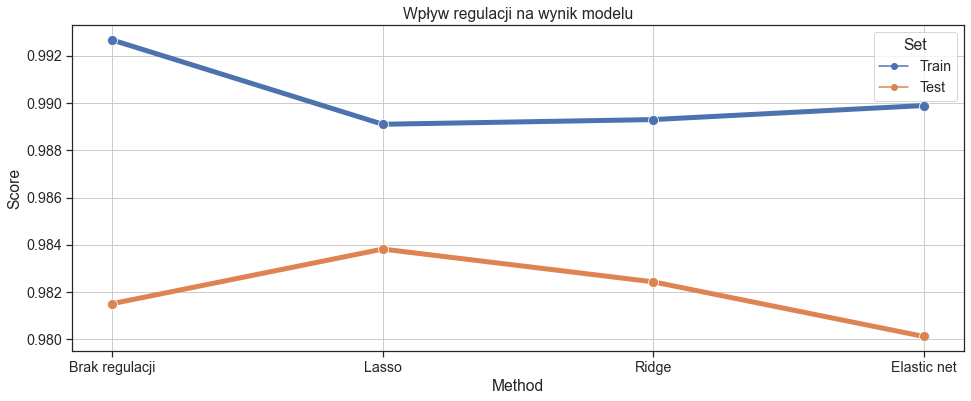

In [8]:
# max_iter=100 <- wartość domyślna
models = [
    LogisticRegression(penalty='none', solver='lbfgs'),
    LogisticRegression(penalty='l1', solver='liblinear'),
    LogisticRegression(penalty='l2', solver='liblinear'),
    LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
]
methods = ['Brak regulacji', 'Lasso', 'Ridge', 'Elastic net']

history = []

for i in range(4):
    model = models[i].fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    history.append((methods[i], train_score, 'Train'))
    history.append((methods[i], test_score, 'Test'))

history_df = pd.DataFrame.from_records(history, columns=['Method', 'Score', 'Set'])
sns.lineplot(data=history_df, x='Method', y='Score', hue='Set', style='Set', dashes=False, markers=['o', 'o'], markersize=10, linewidth=5)
plt.title('Wpływ regulacji na wynik modelu')
plt.show()

Jak widzimy, przy braku jakichkolwiek regulacji model się za bardzo dopasowuje. Najlepszy *score* na zbiorze testowym jest osiągnięty przy użyciu *lasso*. 

#### Confusion matrix - presicion/recall

In [9]:
clf = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train, y_train)
clf.score(X_test, y_test)

0.9838187702265372

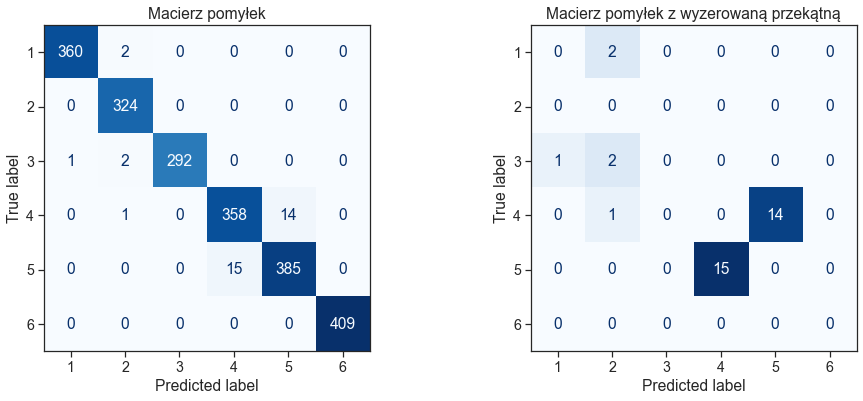

In [10]:
y_test_pred = clf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_test_pred)

fig, axs = plt.subplots(1, 2)
axs[0].grid(False)
axs[1].grid(False)
axs[0].set_title("Macierz pomyłek")
axs[1].set_title("Macierz pomyłek z wyzerowaną przekątną")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=clf.classes_)
disp.plot(colorbar=False, cmap=plt.cm.Blues, ax=axs[0])

np.fill_diagonal(conf_mx, 0)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=clf.classes_)
disp.plot(colorbar=False, cmap=plt.cm.Blues, ax=axs[1])

plt.show()

In [11]:
def precision_recall(y, y_pred):
    return pd.DataFrame(classification_report(
        y, y_pred,
        output_dict = True
    )).iloc[:-1, :-2]

precision_recall(y_test, y_test_pred)

,1,2,3,4,5,6,accuracy
precision,0.997230,0.984802,1.000000,0.959786,0.964912,1.0,0.983819
recall,0.994475,1.000000,0.989831,0.959786,0.962500,1.0,0.983819
f1-score,0.995851,0.992343,0.994889,0.959786,0.963705,1.0,0.983819


Warto przypomnieć, że rzędy w macierzy pomyłek przedstawiają faktyczne klasy, a kolumny to predykcje. Widzimy zatem, że poza kilkoma pojedyńczymi przypadkami najwięcej błędów to klasyfikacja kategorii 4 jako 5 i vice versa (SITTING i STANDING).

#### ROC/AUC

In [12]:
# source - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

y_ = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6])
n_classes = y_.shape[1]
y_score = clf.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

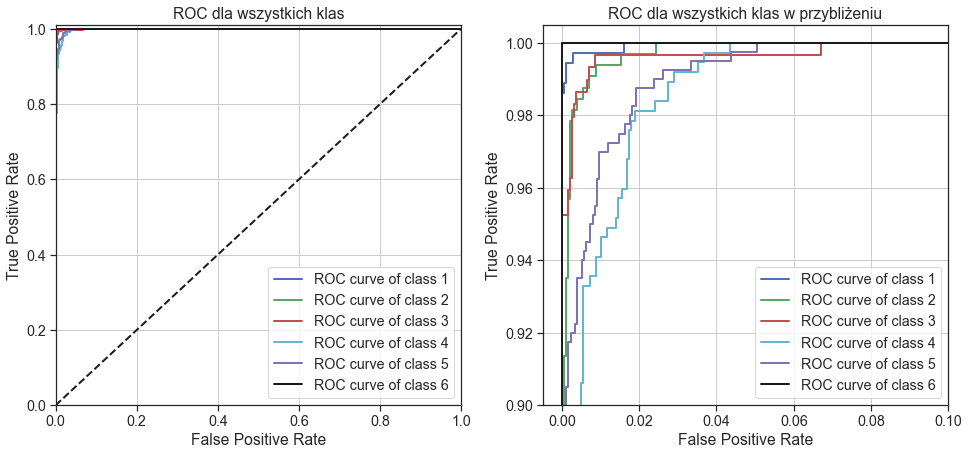

In [13]:
fig, axs = plt.subplots(1, 2,  figsize=(16, 7))
colors = cycle('bgrcmk')

for ax in axs:
    for i, color in zip(range(n_classes), colors):
        ax.plot(
            fpr[i], tpr[i], color=color, linewidth=2,
            label=f"ROC curve of class {i+1}"
        )
    ax.plot([0, 1], [0, 1], "k--", linewidth=2)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    
axs[0].set_title("ROC dla wszystkich klas")
axs[1].set_title("ROC dla wszystkich klas w przybliżeniu")
axs[0].set_xlim([0.0, 1])
axs[0].set_ylim([0.0, 1.01])
axs[1].set_xlim([-0.005, 0.1])
axs[1].set_ylim([0.9, 1.005])
plt.show()

### Linear Support Vector Classification
Przypominamy, że nasze dane są już wyskalowane, więc nie ma potrzeby robić tego na potrzeby SVM.

In [14]:
svm_clf = LinearSVC().fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.9879796578825705

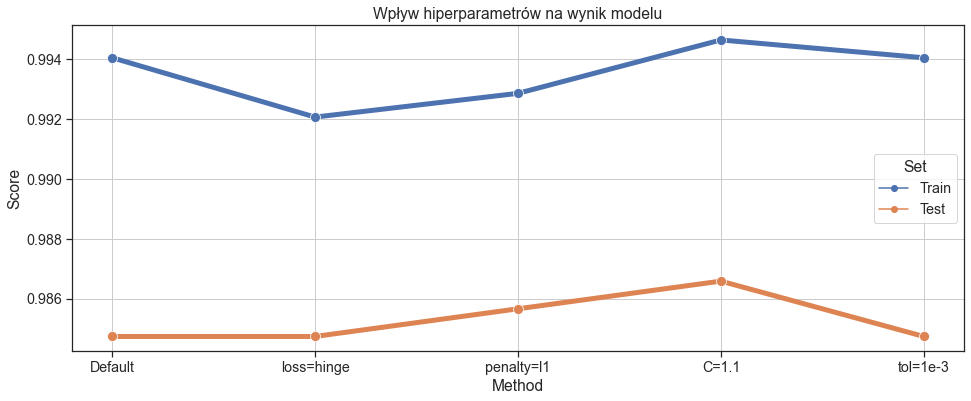

In [15]:
models = [
    LinearSVC(random_state=42),
    LinearSVC(loss='hinge', random_state=42),
    LinearSVC(penalty='l1', dual=False, random_state=42),
    LinearSVC(C=1.1, random_state=42),
    LinearSVC(tol=1e-3, random_state=42)
]
methods = ['Default', 'loss=hinge', 'penalty=l1', 'C=1.1', 'tol=1e-3']

history = []

for i in range(5):
    model = models[i].fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    history.append((methods[i], train_score, 'Train'))
    history.append((methods[i], test_score, 'Test'))

history_df = pd.DataFrame.from_records(history, columns=['Method', 'Score', 'Set'])
sns.lineplot(data=history_df, x='Method', y='Score', hue='Set', style='Set', dashes=False, markers=['o', 'o'], markersize=10, linewidth=5)
plt.title('Wpływ hiperparametrów na wynik modelu')
plt.show()

Spróbowaliśmy kilku zestawów hiperparametrów, zmieniliśmy regulację (`penalty=l1`, `C=1.1`, `tol=1e-3`) czy funkcję strat (`loss=hinge`). Jednak nasze działania przynoszą marginalne zmiany w części setnych. Ponadto, gdybyśmy nie ustawili `random_state` to ranking byłby różny za każdym razem.

In [16]:
def plot_confusion_matrix(y_test, y_pred):
    conf_mx = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=[1, 2, 3, 4, 5, 6])
    disp.plot(colorbar=False, cmap=plt.cm.Blues)
    plt.grid(False)
    disp.figure_.set_size_inches(4, 4)

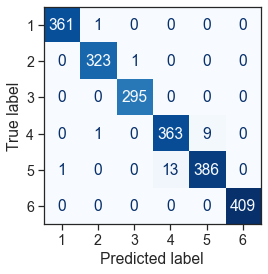

In [17]:
y_test_pred = svm_clf.predict(X_test)
plot_confusion_matrix(y_test, y_test_pred)

In [18]:
precision_recall(y_test, y_test_pred)

,1,2,3,4,5,6,accuracy
precision,0.997238,0.993846,0.996622,0.965426,0.977215,1.0,0.98798
recall,0.997238,0.996914,1.000000,0.973190,0.965000,1.0,0.98798
f1-score,0.997238,0.995378,0.998308,0.969292,0.971069,1.0,0.98798


Widzimy, że i tutaj problem leży w rozpoznawaniu między kategorią 4 a 5.

### Drzewa decyzyjne

In [19]:
tree_clf = DecisionTreeClassifier().fit(X_train, y_train)
tree_score = tree_clf.score(X_test, y_test)
tree_score

0.9288025889967637

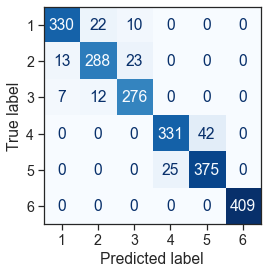

In [20]:
y_pred_tree = tree_clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred_tree)

In [21]:
precision_recall(y_test, y_pred_tree)

,1,2,3,4,5,6,accuracy
precision,0.942857,0.894410,0.893204,0.929775,0.899281,1.0,0.928803
recall,0.911602,0.888889,0.935593,0.887399,0.937500,1.0,0.928803
f1-score,0.926966,0.891641,0.913907,0.908093,0.917993,1.0,0.928803


Wyniki nie są zadowalające - jedynie szóstą kategorię jesteśmy w stanie bezproblemowo sklasyfikować.

### Metoda *k* najbliższych sąsiadów

In [22]:
neighbors_clf = KNeighborsClassifier().fit(X_train, y_train)
neighbors_score = neighbors_clf.score(X_test, y_test)
neighbors_score

0.9583911234396671

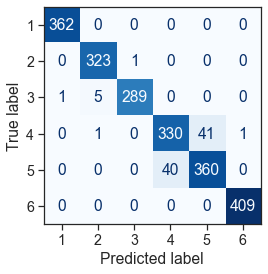

In [23]:
y_pred_neighbors = neighbors_clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred_neighbors)

In [24]:
precision_recall(y_test, y_pred_neighbors)

,1,2,3,4,5,6,accuracy
precision,0.997245,0.981763,0.996552,0.891892,0.897756,0.997561,0.958391
recall,1.000000,0.996914,0.979661,0.884718,0.900000,1.000000,0.958391
f1-score,0.998621,0.989280,0.988034,0.888291,0.898876,0.998779,0.958391


Dokładność wyższa niż w przypadku drzew decyzyjnych, ale w dalszym ciągu mamy problemy z rozróżnieniem kategorii $4$ i $5$.

### Naiwny klasyfikator bayesowski

Zanim przystąpimy do trenowania modelu, spróbujmy, przy użyciu `GridSearchCV` usunąć niektóre kolumny za pomocą wcześniej stworzonej klasy `CorrelatedColumnsRemover` i sprawdzić, jaki będzie to miało wpływ na skuteczność modelu.

In [60]:
gnb_pipeline = Pipeline([
    ('remover', CorrelatedColumnsRemover()),
    ('gnb', GaussianNB())
])

In [61]:
gnb_pipeline_search = GridSearchCV(
    gnb_pipeline, 
    dict(remover__threshold=[1, 0.99, 0.98, 0.96, 0.92, 0.84, 0.7, 0.5, 0.3, 0.1]), 
    scoring = 'accuracy', 
    cv = 5
)
gnb_pipeline_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('remover', CorrelatedColumnsRemover()),
                                       ('gnb', GaussianNB())]),
             param_grid={'remover__threshold': [1, 0.99, 0.98, 0.96, 0.92, 0.84,
                                                0.7, 0.5, 0.3, 0.1]},
             scoring='accuracy')

In [62]:
gnb_pipeline_search.cv_results_['mean_test_score']

array([0.75841388, 0.66349017, 0.68013914, 0.77288404, 0.83432101,
       0.84641298, 0.85057492, 0.84680803, 0.66369271, 0.59393321])

In [63]:
gnb_pipeline_search.best_params_, gnb_pipeline_search.best_score_

({'remover__threshold': 0.7}, 0.8505749246877116)

Text(0.5, 1.0, 'Wpływ parametru `threshold` na dokładność modelu GaussianNB')

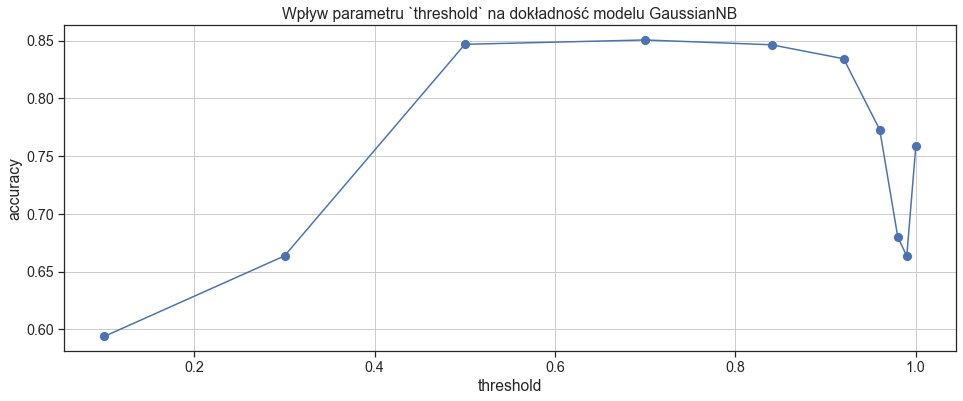

In [164]:
sns.lineplot(
    x = [x['remover__threshold'] for x in gnb_pipeline_search.cv_results_['params']],
    y = gnb_pipeline_search.cv_results_['mean_test_score'],
).set_xlabel('threshold')

sns.scatterplot(
    x = [x['remover__threshold'] for x in gnb_pipeline_search.cv_results_['params']],
    y = gnb_pipeline_search.cv_results_['mean_test_score'],
    s = 100
).set_ylabel('accuracy')

plt.title('Wpływ parametru `threshold` na dokładność modelu GaussianNB')

Najwyższą skuteczność osiągnęliśmy dla parametru `threshold` równego 0.7. Zobaczmy, jak nasz model zaprezentuje się na danych testowych:

In [29]:
gnb_remover = CorrelatedColumnsRemover(threshold = 0.7).fit(X_train)
X_train_gnb = gnb_remover.transform(X_train)
X_test_gnb = gnb_remover.transform(X_test)

gnb_clf = GaussianNB()
gnb_clf.fit(X_train_gnb, y_train)
y_pred_gnb = gnb_clf.predict(X_test_gnb)
gnb_score = accuracy_score(y_test, y_pred_gnb)
gnb_score

0.8317152103559871

### Las losowy

Przejdźmy do metod zespołowych. Zanim sprawdzimy efektywność klasyfikatora `RandomForestClassifier`, dobierzemy optymalną wartość parametru `n_estimators`.

In [64]:
rnd_search = GridSearchCV(RandomForestClassifier(), {
    'n_estimators': [5, 13, 30, 75, 200, 500, 750, 1000]
}, scoring = 'accuracy', cv = 3)
%time rnd_search.fit(X_train, y_train)

CPU times: total: 9min 50s
Wall time: 9min 57s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [5, 13, 30, 75, 200, 500, 750, 1000]},
             scoring='accuracy')

In [65]:
rnd_search.cv_results_['mean_test_score']

array([0.93757432, 0.96036465, 0.96294094, 0.96630995, 0.96710266,
       0.96789536, 0.96829172, 0.96848989])

In [66]:
rnd_search.best_params_, rnd_search.best_score_

({'n_estimators': 1000}, 0.9684898929845422)

Text(0.5, 1.0, 'Wpływ parametru `n_estimators` na dokładność modelu')

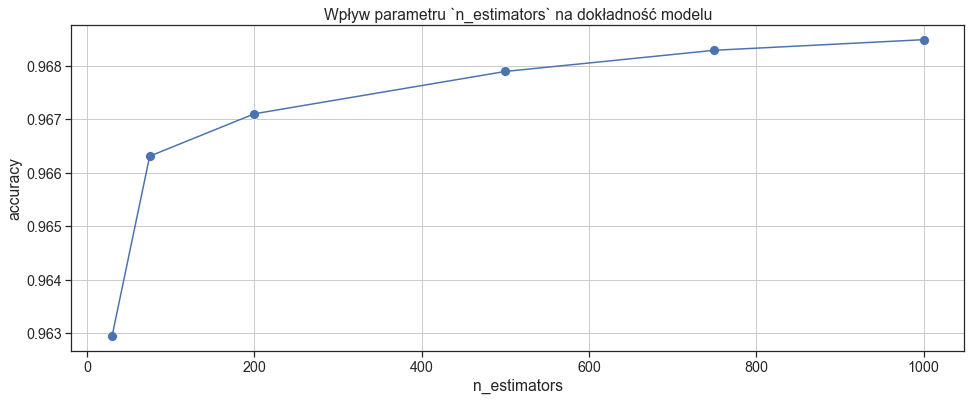

In [161]:
sns.lineplot(
    x = [x['n_estimators'] for x in rnd_search.cv_results_['params']][2:],
    y = rnd_search.cv_results_['mean_test_score'][2:],
).set_xlabel('n_estimators')

sns.scatterplot(
    x = [x['n_estimators'] for x in rnd_search.cv_results_['params']][2:],
    y = rnd_search.cv_results_['mean_test_score'][2:],
    s = 100
).set_ylabel('accuracy')

plt.title('Wpływ parametru `n_estimators` na dokładność modelu')

Zwiększenie liczby estymatorów zwiększa dokładność modelu. Sprawdźmy jego dokładność na zbiorze testowym:

In [67]:
rnd_clf = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [68]:
y_pred_rnd = rnd_clf.predict(X_test)
rnd_score = accuracy_score(y_test, y_pred_rnd)
rnd_score

0.9750346740638003

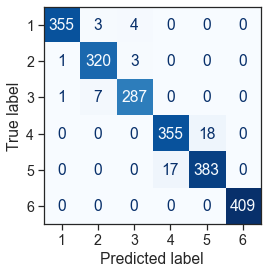

In [69]:
plot_confusion_matrix(y_test, y_pred_rnd)

In [70]:
precision_recall(y_test, y_pred_rnd)

,1,2,3,4,5,6,accuracy
precision,0.994398,0.969697,0.976190,0.954301,0.955112,1.0,0.975035
recall,0.980663,0.987654,0.972881,0.951743,0.957500,1.0,0.975035
f1-score,0.987483,0.978593,0.974533,0.953020,0.956305,1.0,0.975035


### Wzmacnianie adaptacyjne

Najpierw dobierzmy optymalne parametry:

In [123]:
ada_search = RandomizedSearchCV(
    AdaBoostClassifier(DecisionTreeClassifier()),
    {
        'n_estimators': range(2, 1000),
        'learning_rate': scipy.stats.uniform(0, 2)
    },
    n_iter = 100
).fit(X_train, y_train)

In [124]:
(ada_search.best_params_, ada_search.best_score_)

({'learning_rate': 1.0296233638612644, 'n_estimators': 931}, 0.915184134865419)

<AxesSubplot:xlabel='n_estimators', ylabel='learning_rate'>

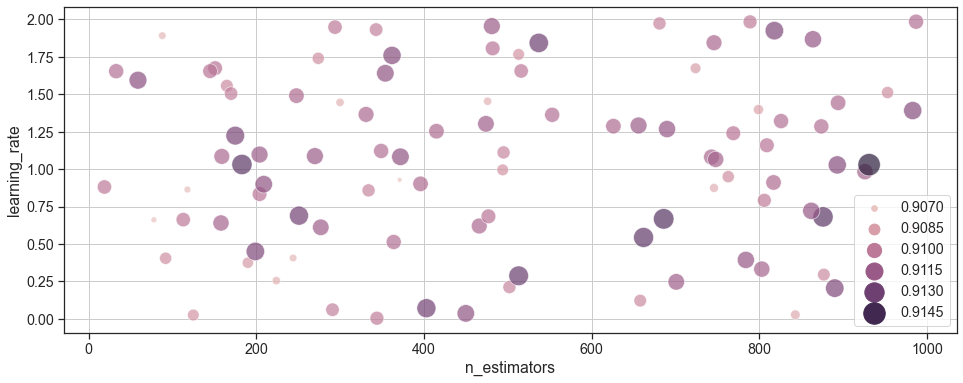

In [125]:
ada_search_df = pd.DataFrame(ada_search.cv_results_['params'])
ada_scores = ada_search.cv_results_['mean_test_score']
sns.scatterplot(
    data = ada_search_df,
    x = 'n_estimators',
    y = 'learning_rate',
    size = ada_scores,
    hue = ada_scores,
    sizes=(1, 500),
    alpha = 0.7
)

Następnie sprawdzamy dokładność na zbiorze testowym.

In [126]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=931, learning_rate=1.023)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=1.023,
                   n_estimators=931)

In [127]:
y_pred_ada = ada_clf.predict(X_test)

In [128]:
ada_score = accuracy_score(y_test, y_pred_ada)
ada_score

0.9255663430420712

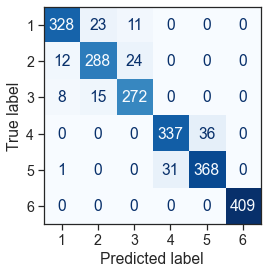

In [129]:
plot_confusion_matrix(y_test, y_pred_ada)

In [130]:
precision_recall(y_test, y_pred_ada)

,1,2,3,4,5,6,accuracy
precision,0.939828,0.883436,0.885993,0.915761,0.910891,1.0,0.925566
recall,0.906077,0.888889,0.922034,0.903485,0.920000,1.0,0.925566
f1-score,0.922644,0.886154,0.903654,0.909582,0.915423,1.0,0.925566


### Wzmacnianie gradientowe

#### GradientBoostingClassifier

In [44]:
grd_clf = GradientBoostingClassifier(max_depth = 2, n_estimators = 3, learning_rate = 1.0)
grd_clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=2, n_estimators=3)

In [45]:
y_pred_grd = grd_clf.predict(X_test)

In [46]:
grd_score = accuracy_score(y_test, y_pred_grd)
grd_score

0.9209431345353676

#### XGBoost

In [47]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(eval_metric = 'merror')
xgb_clf.fit(X_train, list(y_train - 1)) #numery klas muszą się zaczynać od 0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='merror', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [48]:
y_pred_xgb = xgb_clf.predict(X_test) + 1

In [49]:
xgb_score = accuracy_score(y_test, y_pred_xgb)
xgb_score

0.9856680536292187

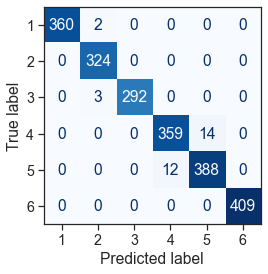

In [50]:
plot_confusion_matrix(y_test, y_pred_xgb)

In [51]:
precision_recall(y_test, y_pred_xgb)

,1,2,3,4,5,6,accuracy
precision,1.000000,0.984802,1.000000,0.967655,0.965174,1.0,0.985668
recall,0.994475,1.000000,0.989831,0.962466,0.970000,1.0,0.985668
f1-score,0.997230,0.992343,0.994889,0.965054,0.967581,1.0,0.985668


`XGBClassifier`, w przeciwieństwie do dwóch poprzednich klasyfikatorów boostujących, spisał się znakomicie, w szczególności dobrze poradził sobie z wykrywaniem kategorii $4$ i $5$.

### Głosowanie miękkie

In [83]:
estimators = [
    ('lreg', LogisticRegression(penalty='l1', solver='liblinear')),
    ('svm', SVC(kernel = 'linear', probability = True)),
    ('rnd', RandomForestClassifier(n_estimators = 1000, n_jobs = -1)),
    ('xgb', XGBClassifier(eval_metric = 'merror')),
    ('knb', KNeighborsClassifier())
]

In [77]:
soft_clf = VotingClassifier(estimators = estimators, voting = 'soft')
soft_clf.fit(X_train, y_train - 1) #XGB wymaga wartości całkowitych zaczynających się od zera
y_soft_clf = soft_clf.predict(X_test) + 1

In [78]:
soft_score = accuracy_score(y_test, y_soft_clf)
soft_score

0.9865926953305594

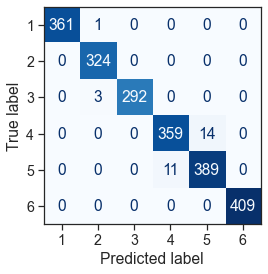

In [79]:
plot_confusion_matrix(y_test, y_soft_clf)

In [80]:
precision_recall(y_test, y_soft_clf)

,1,2,3,4,5,6,accuracy
precision,1.000000,0.987805,1.000000,0.970270,0.965261,1.0,0.986593
recall,0.997238,1.000000,0.989831,0.962466,0.972500,1.0,0.986593
f1-score,0.998617,0.993865,0.994889,0.966353,0.968867,1.0,0.986593


Również tutaj uzyskaliśmy wysoką dokładność, tj. powyżej 98%. Klasyfikator cechuje się również wysoką pełnością i precyzją (powyżej 96%) przy rozpoznawaniu najbardziej problematycznych kategorii, tj. $4$ i $5$.

Odnotujmy, że w tym przypadku dokładności modelu nie poprawia usuwanie kolumn.

In [175]:
rmv_voting_clf = Pipeline([
    ('rmv', CorrelatedColumnsRemover()),
    ('clf', VotingClassifier(estimators = estimators, voting = 'soft'))
])

In [176]:
rmv_voting_clf_search = GridSearchCV(rmv_voting_clf, dict(rmv__threshold = [1.0, 0.98, 0.7]), cv = 3)

In [177]:
rmv_voting_clf_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('rmv', CorrelatedColumnsRemover()),
                                       ('clf',
                                        VotingClassifier(estimators=[('lreg',
                                                                      LogisticRegression(penalty='l1',
                                                                                         solver='liblinear')),
                                                                     ('svm',
                                                                      SVC(kernel='linear',
                                                                          probability=True)),
                                                                     ('rnd',
                                                                      RandomForestClassifier(n_estimators=1000,
                                                                                             n_jobs=-1)),
         

In [182]:
pd.DataFrame(final_model_search.cv_results_)[['params', 'mean_test_score']]

,params,mean_test_score
0,{'rmv__threshold': 1.0},0.985137
1,{'rmv__threshold': 0.98},0.984939
2,{'rmv__threshold': 0.7},0.971463


## Podsumowanie
Osiągnęliśmy bardzo dobre rezultaty w wypróbowanych modelach. Objawiały się podobne problemy w klasyfikacji, głównie między klasami $4$ i $5$, a także pojedyńcze błędy przy trzech pierwszych kategoriach. 

Właśnie ze względu na podobieństwo rezultatów zwykły *score* wydaje się najprostszy do wybrania najlepszych modeli. Wygląda to następująco:
* najlepsze wyniki (powyżej 0.98) zostały osiągnięte dla: *LogisticRegression*, *LinearSVC*, *VotingClassifier*, *XGBoost*
* następnie plasują się: 
    * *RandomForestClassifier* (0.97)
    * *KNeighborsClassifier* (0.95)
    * *AdaBoostClassifier* (0.93) 
    * *DecisionTreeClassifier* (0.93)
    * *GradientBoostingClassifier* (0.92)
    * *GaussianNB* (0.85)